This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pydelfi.score as score

tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

In [2]:
# we define a few hyper parameters here
np.random.seed(13)
n = 1000 # total number of data points for NF
n_sims = 10000  # total number of points for drawing
n_class = 1 # number of different cosmologies for the training
q_prior = np.linspace(1.0, 2.0, n_sims) #np.random.uniform(0, 1, n)
q_fid = np.asarray([1.5]) #np.random.uniform(0, 1, 1)

In [3]:
q_fid 

array([1.5])

In [4]:
# in order to perform the compressions, we need a few things
n_vec = 50
mu = np.arange(1, n_vec+1)/(q_fid * n_vec)
Cinv = n_vec**2*np.eye(n_vec)/ np.arange(1, n_vec+1)
dmudt = -np.arange(1, n_vec+1)/(q_fid**2 * n_vec)
dmudt = np.reshape(dmudt, [1, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [5]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
q_fid_obs = 1.2
d_vec_obs = np.zeros((1, n_vec))
for j in range(1, n_vec+1):
    d_vec_obs[0, j-1] = np.random.gamma(j / q_fid_obs**2, q_fid_obs / n_vec)

# we also create the data corresponding to a fixed noise, but different q
d_vec_q = np.zeros((n_sims, n_vec))
for i, q in enumerate(q_prior):
    for j in range(1, n_vec+1):
        np.random.seed(j)
        d_vec_q[i, j-1] = np.random.gamma(j / q**2, q / n_vec)
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(10000, 50) (1, 50)


In [6]:
d_vec_obs

array([[0.02740799, 0.02425176, 0.05803965, 0.12531366, 0.11820649,
        0.18044246, 0.06354602, 0.15880653, 0.12826348, 0.22199581,
        0.19673581, 0.20077193, 0.40083408, 0.16043108, 0.34455872,
        0.2473932 , 0.29512485, 0.42549664, 0.18947907, 0.37066438,
        0.54373514, 0.30408247, 0.33389361, 0.43180655, 0.27640528,
        0.394077  , 0.56991472, 0.68138134, 0.4666655 , 0.39298143,
        0.50840275, 0.57787691, 0.50493595, 0.73006275, 0.84611151,
        0.63589771, 0.54886192, 0.41798861, 0.55249331, 0.71734376,
        0.79969479, 0.6656209 , 0.66076301, 0.60961445, 0.64335071,
        0.64914912, 0.84060476, 0.69669686, 0.88955313, 0.94543232]])

In [7]:
# we create here the data to compress and to feed to the NF
d_vec = np.zeros((n, n_vec))
for i in range(n):
    for j in range(1, n_vec+1):
        d_vec[i, j-1] = np.random.gamma(j / q_fid**2, q_fid / n_vec)
        
d_vec_keep_copy = np.zeros((n, n_vec))
for i in range(n):
    for j in range(1, n_vec+1):
        d_vec_keep_copy[i, j-1] = np.random.gamma(j / q_fid_obs**2, q_fid_obs / n_vec)

# we also create the data corresponding to fixed noise, at the fiducial q
d_vec_q_shift = np.zeros((1, n_vec))
#np.random.seed(13)
for _ in range(1):
    #np.random.seed(13)
    for j in range(1, n_vec+1):
        np.random.seed(j)
        d_vec_q_shift[0, j-1] = np.random.gamma(j / q_fid**2, q_fid / n_vec)

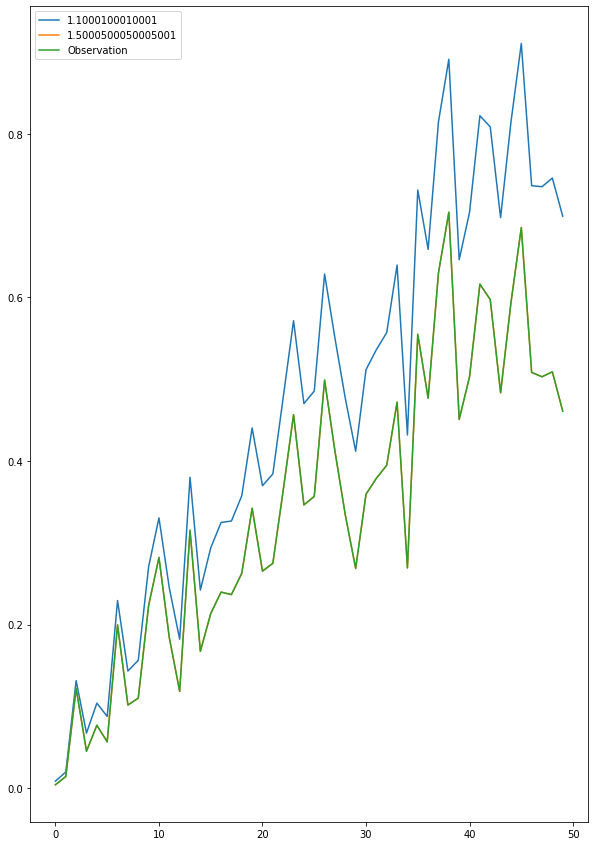

In [8]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in [1000, 5000]:
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
    #print(d_vec_q[index][40])
#for index in range(n):
#    plt.plot(np.arange(n_vec), d_vec[index],)
plt.plot(np.arange(n_vec), d_vec_q_shift[0], label='Observation')
plt.legend();

In [9]:
# we need to retrieve all the needed summaries here, so:
# 1) the summaries of the fixed noise vectors
# 2) the summary of the observation
# 3) the summaries of the noise realisations at the fiducial point
# 4) the summary of the shift vector, i.e. the fixed noise at the fiducial value
summaries_posterior = []
for index in range(n_sims):
    summaries_posterior.append(compressor(d_vec_q[index]))  # it should be in the whole prior 
summaries_posterior = np.asarray(summaries_posterior)

summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec[index]))  # it should be at 1.5
summaries_noise = np.asarray(summaries_noise)

summaries_noise_kept = []
for index in range(n):
    summaries_noise_kept.append(compressor(d_vec_keep_copy[index]))  # it should be at 1.2
summaries_noise_kept = np.asarray(summaries_noise_kept)

summary_obs = compressor(d_vec_obs[0])  # it should be at 1.5
summary_obs = np.reshape(summary_obs, [1, 1])

summary_shift = compressor(d_vec_q_shift[0])  # it should be at 1.5
summary_shift = np.reshape(summary_shift, [1, 1])

#summary_shift_kept = compressor(d_vec_shift_keep_copy[0])  # it should be at 0.2
#summary_shift_kept = np.reshape(summary_shift_kept, [1, 1])

In [10]:
compressor(d_vec_obs[0])

array([1.07883866])

In [11]:
# now we plot a few things to make sure everything makes sense

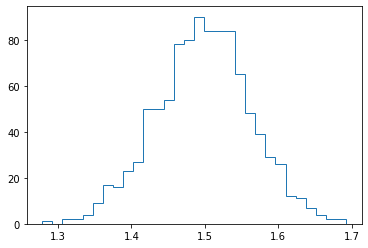

In [12]:
# first we plot the distribution of the noisy summaries
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step');

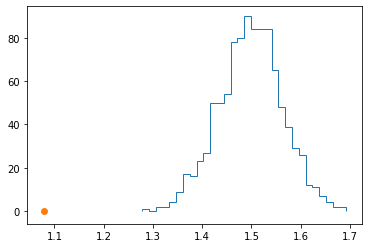

In [13]:
# we also check if the observation is within the summaries of the fiducial noisy data
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summary_obs, np.zeros(1));

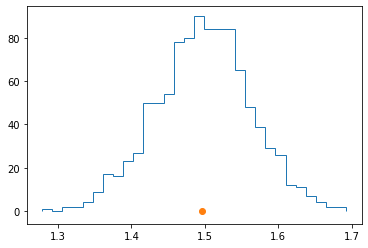

In [14]:
# we also check if the shift FN is within the summaries of the fiducial noisy data
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summary_shift, np.zeros(1))

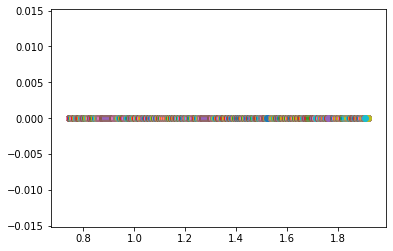

In [15]:
# and finally we look at the "posterior distribution"
# then we plot the distribution of the noisy summaries with all the FN summaries
for index in range(n_sims):
    plt.scatter(summaries_posterior[index], np.zeros(1))

# Gaussianisation of the latent space

At this stage, we finally need to set up the NF between the obtaines sample of summaries, in order to have the bijection to that space. We will use Inverse Autoregressive Flows (IAFs).

In [16]:
# we define a few variables here, and reset the graph
DTYPE=tf.float32
NP_DTYPE=np.float32
tf.reset_default_graph()
batch_size = 128
num_bijectors = 8

# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=summaries_noise.shape[0])
dataset = dataset.prefetch(3 * batch_size)
dataset = dataset.batch(batch_size)
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [17]:
# this is the distribution to match
#base_dist = tfd.Normal(loc=0.0, scale=1.0)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([1], DTYPE))

In [18]:
# we define the flow here
bijectors = []
for i in range(num_bijectors):
    bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[1024, 1024]))))
    bijectors.append(tfb.Permute(permutation=[0]))
# discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [19]:
# this is the transformed distribution, i.e. the distribution of the summaries
dist = tfd.TransformedDistribution(
            distribution=base_dist,
            bijector=flow_bijector)

In [20]:
# optimisation
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:
Please use `layer.__call__` method instead.


0 2.0244884
500 -1.2940731
1000 -1.3356566
1500 -1.3530855


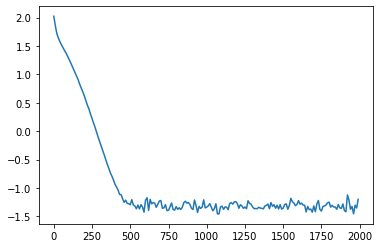

In [21]:
# and finally we train the NF as well
sess = tf.Session()
sess.run(tf.global_variables_initializer())
NUM_STEPS = 2000#int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 10 == 0:
        global_step.append(i)
        losses.append(np_loss)
        #g_losses.append(gl)
    if i % int(5e2) == 0:
        print(i, np_loss)
start = 0
plt.plot(global_step, losses[start:])

In [22]:
# now we need to look at samples which we inject in the flow to the Gaussian domain
# just to make sure the gaussianisation was successful

In [23]:
# we look at the flow injection, which corresponds to the inverse pass
x = x_samples
samples = [x]
names = [base_dist.name]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
    names.append(bijector.name)
samples_plot = [samples[0], samples[-1], base_dist.sample(128)]
names=['Latent', 'Mapped latent', 'Original Gaussian']

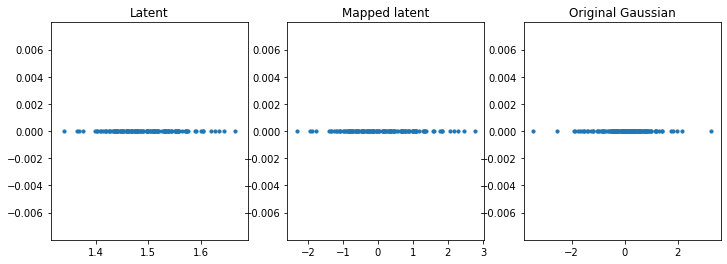

In [24]:
noise_flow = sess.run(samples_plot)
f, arr = plt.subplots(1, len(noise_flow), figsize=(4 * (len(noise_flow)), 4))
X0 = noise_flow[0]
for i in range(len(noise_flow)):
    X1 = noise_flow[i]
    arr[i].scatter(X1, np.zeros_like(X1), s=10)
    arr[i].set_title(names[i])

In [25]:
print(noise_flow[0].mean())
print(noise_flow[1].mean())
print(noise_flow[2].mean())
print(noise_flow[0].std())
print(noise_flow[1].std())
print(noise_flow[2].std())

1.4947345
0.10873287
0.021949384
0.06147219
0.9632296
0.92964286


In [26]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summary_obs.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_obs = data_iterator.get_next()

In [27]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summaries_posterior.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n_sims)
dataset = dataset.batch(n_sims)
data_iterator = dataset.make_one_shot_iterator()
x_samples_posterior = data_iterator.get_next()

In [28]:
# we inject the shift as well
dataset = tf.data.Dataset.from_tensor_slices(summary_shift.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_shift = data_iterator.get_next()

In [29]:
# we inject the FN observation in the flow, since we need the fiducial one for the posterior evaluation
x = x_samples_shift
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
shift_flow_ = samples[-1]
shift = sess.run(shift_flow_)

In [30]:
shift

array([[0.12756039]], dtype=float32)

In [31]:
# we inject the posterior points
x = x_samples_posterior
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
posterior_points_ = samples[-1]
posterior_points = sess.run(posterior_points_)

In [32]:
# check that there are no duplicates
posterior_points__ = list(np.reshape(posterior_points, [-1]))

import collections
print ([item for item, count in collections.Counter(posterior_points__).items() if count > 1])

[]


In [33]:
# we need to shift the posterior points as we want the mean to be captured, and they have fixed noise
posterior_points_mu = posterior_points - shift[0][0]

In [34]:
# finally, we try to evaluate the posterior
# we first inject the observation in the flow as well
x = x_samples_obs
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
observation_ = samples[-1]
compressed_obs = sess.run(observation_)

In [35]:
compressed_obs[0][0]

-6.4080863

In [36]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_prior[index], like_value

In [37]:
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [38]:
d_vec_obs_keep[0]

array([0.02740799, 0.02425176, 0.05803965, 0.12531366, 0.11820649,
       0.18044246, 0.06354602, 0.15880653, 0.12826348, 0.22199581,
       0.19673581, 0.20077193, 0.40083408, 0.16043108, 0.34455872,
       0.2473932 , 0.29512485, 0.42549664, 0.18947907, 0.37066438,
       0.54373514, 0.30408247, 0.33389361, 0.43180655, 0.27640528,
       0.394077  , 0.56991472, 0.68138134, 0.4666655 , 0.39298143,
       0.50840275, 0.57787691, 0.50493595, 0.73006275, 0.84611151,
       0.63589771, 0.54886192, 0.41798861, 0.55249331, 0.71734376,
       0.79969479, 0.6656209 , 0.66076301, 0.60961445, 0.64335071,
       0.64914912, 0.84060476, 0.69669686, 0.88955313, 0.94543232])

In [39]:
import scipy.special as sps
theo_post = np.zeros((n_sims, 2))
for i, q in enumerate(q_prior):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

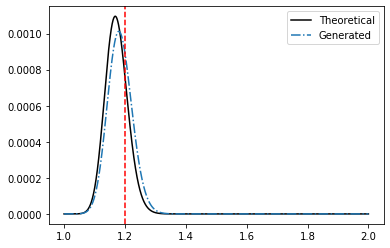

In [40]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')

In [42]:
# other tests to understand what is going wrong
# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise_kept.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n)
dataset = dataset.batch(n)
data_iterator = dataset.make_one_shot_iterator()
x_samples_kept = data_iterator.get_next()

x = x_samples_kept
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
kept = samples[-1]
noise_flow_kept = sess.run(kept)

#print(posterior_point_mu_kept[0][0])
print(noise_flow_kept.mean())
print(noise_flow_kept.std())

-5.693487
0.9827029


In [17]:
# separate test for this case

In [45]:
def manual_gauss(data):
    return (data - summaries_noise.mean()) / summaries_noise.std()

noise_flow = manual_gauss(summaries_noise)
noise_flow_kept = manual_gauss(summaries_noise_kept)
compressed_obs = manual_gauss(summary_obs)
posterior_points = manual_gauss(summaries_posterior)
shift = manual_gauss(summary_shift)
posterior_points_mu = posterior_points  - shift
#shift_kept = manual_gauss(summary_shift_kept)
#posterior_point_mu_kept = shift_kept - shift

In [46]:
print(noise_flow.mean())
print(noise_flow.std())

-2.779998453661392e-15
1.0


In [47]:
#print(posterior_point_mu_kept[0][0])
print(noise_flow_kept.mean())
print(noise_flow_kept.std())

-5.820090377735347
0.977489239759547


In [48]:
shift 

array([[-0.0299252]])

In [49]:
compressed_obs

array([[-6.53089909]])

In [50]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_prior[index], like_value
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [51]:
import scipy.special as sps
theo_post = np.zeros((n_sims, 2))
for i, q in enumerate(q_prior):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

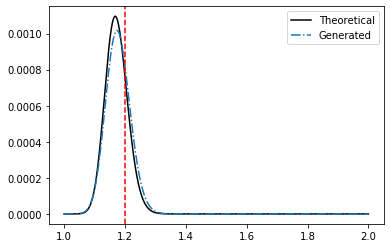

In [52]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')

Automatically created module for IPython interactive environment


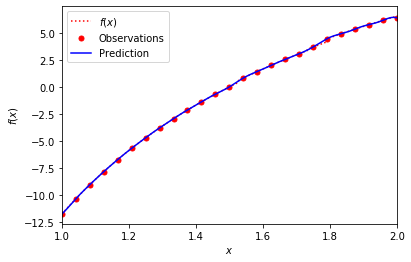

In [138]:
# we test the GP here, and its
# capability of interpolating between values
%matplotlib inline
print(__doc__)

# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    index, = np.where(q_prior == x)
    return posterior_points_mu[index]

# ----------------------------------------------------------------------
#  First the noiseless case
gp_points_number = 25
idx = np.arange(n_sims)
np.random.shuffle(idx)
idx = np.linspace(0, n_sims-1, gp_points_number, dtype=np.int64) #idx[:5]
X = np.atleast_2d(q_prior[idx]).T #np.atleast_2d(np.arange(10)).T

# Observations
y = posterior_points_mu[idx] #f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(1, 2, n_sims)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, np.take(posterior_points_mu, np.arange(n_sims)), 'r:', label=r'$f(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(1.0, 2)
#plt.ylim(-5, 10)
plt.legend(loc='upper left')
plt.show()

In [139]:
y_pred[342:346]

array([[-10.59598752],
       [-10.59251528],
       [-10.58904423],
       [-10.58557439]])

In [140]:
posterior_points_mu[342:346]

array([[-10.58457451],
       [-10.58128205],
       [-10.57799022],
       [-10.57469902]])

In [141]:
idx

array([   0,  416,  833, 1249, 1666, 2083, 2499, 2916, 3333, 3749, 4166,
       4582, 4999, 5416, 5832, 6249, 6666, 7082, 7499, 7915, 8332, 8749,
       9165, 9582, 9999], dtype=int64)

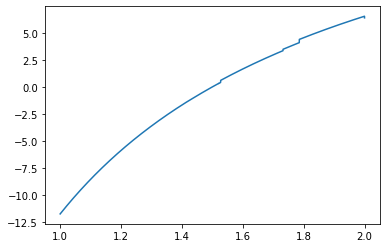

In [142]:
plt.plot(x, posterior_points_mu)

In [143]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])
is_sorted(posterior_points_mu)

False

In [144]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(y_pred):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_prior[index], like_value
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [145]:
import scipy.special as sps
theo_post = np.zeros((n_sims, 2))
for i, q in enumerate(q_prior):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

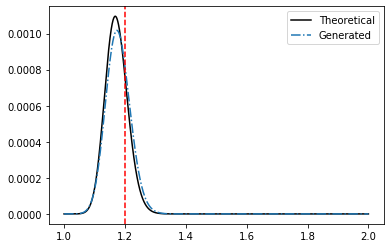

In [146]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')

# Posterior evaluation

After all we've done, we do have a tool that has gaussianised the likelihood. In fact, for a given parameter q, we can create an observation with fixed noise and feed it through the encoder+NF to get a point $y$. The likelihood is a unit Gaussian, with mean given by $\mu = y - z$, with $z$ the output of encoder+NF for the fiducial fixed noise realisation. In this sense, we only need to run 1 simulation per cosmological parameter.

A general observation, instead, is simply encoded and injected in the NF, thus getting the observed compressed data vector.

In order to check if we built a useful tool, we are going to calculate the posterior thus obtained. If this works, we can then build on top of this. But, as I expect, it does not work, well... we will need to re-think all of this.

In [44]:
# first thing we create an observation